In [22]:
'''Imports'''
import numpy as np
import pandas as pd
# scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# regressors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
# CV
from sklearn.model_selection import  KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.base import clone
import warnings
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import re
from sklearn.impute import SimpleImputer
randomstate = 42
warnings.filterwarnings('ignore')

In [33]:
'''Pre-Processing'''
original = pd.read_csv('health_insurance_train.csv')
data = pd.read_csv('health_insurance_train.csv')
data = data.replace({'yes': 1, 'no': 0})
encoder = OneHotEncoder(sparse_output=False, drop=None)  # keep all categories
category_encoded = encoder.fit_transform(data[['education']])
feature_names = encoder.get_feature_names_out(['education'])
data = data.drop('education', axis=1)
data[feature_names] = category_encoded
category_encoded = encoder.fit_transform(data[['race']])
feature_names = encoder.get_feature_names_out(['race'])
data = data.drop('race', axis=1)
data[feature_names] = category_encoded
category_encoded = encoder.fit_transform(data[['region']])
feature_names = encoder.get_feature_names_out(['region'])
data = data.drop('region', axis=1)
data[feature_names] = category_encoded
data = data.replace('', np.nan)
imputer = SimpleImputer(strategy='mean')
imputer.fit(data)
data_transformed = imputer.transform(data)
data = pd.DataFrame(data_transformed, columns=data.columns)
#data = data.dropna()


auto_data = pd.read_csv('health_insurance_autograde.csv')
auto_data = auto_data.replace({'yes': 1, 'no': 0})
encoder = OneHotEncoder(sparse_output=False, drop=None)  # keep all categories
category_encoded = encoder.fit_transform(auto_data[['education']])
feature_names = encoder.get_feature_names_out(['education'])
auto_data = auto_data.drop('education', axis=1)
auto_data[feature_names] = category_encoded
category_encoded = encoder.fit_transform(auto_data[['race']])
feature_names = encoder.get_feature_names_out(['race'])
auto_data = auto_data.drop('race', axis=1)
auto_data[feature_names] = category_encoded
category_encoded = encoder.fit_transform(auto_data[['region']])
feature_names = encoder.get_feature_names_out(['region'])
auto_data = auto_data.drop('region', axis=1)
auto_data[feature_names] = category_encoded
auto_data = auto_data.replace('', np.nan)
imputer = SimpleImputer(strategy='mean')
imputer.fit(auto_data)
auto_data_transformed = imputer.transform(auto_data)
auto_data = pd.DataFrame(auto_data_transformed, columns=auto_data.columns)
#auto_data = auto_data.dropna()


x_auto = auto_data.to_numpy()
y_num = data["whrswk"].to_numpy()
x_num = data.drop("whrswk", axis=1).to_numpy()

stanscaler = StandardScaler()
minmaxscaler = MinMaxScaler()

stanscaler.fit(x_num)
x_num_stan = stanscaler.transform(x_num)
minmaxscaler.fit(x_num)
x_num_minmax = minmaxscaler.transform(x_num)

stanscaler.fit(x_auto)
x_auto_stan = stanscaler.transform(x_auto)
minmaxscaler.fit(x_auto)
x_auto_minmax = minmaxscaler.transform(x_auto)
x_num_minmax.shape

(5000, 22)

In [24]:
'''Cross Validation'''
def nested_cv(X, y, model, param_grid, outer_cv=5, inner_cv=6, model_name=""):
    outer_scores = []
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    if param_grid:
        print(f"{model_name} - Finding best parameters using inner CV...")
        inner_cv_splitter = KFold(n_splits=inner_cv, shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(
            estimator=clone(model),
            param_grid=param_grid,
            cv=inner_cv_splitter,
            scoring=mae_scorer,
            n_jobs=-1
        )
        
        grid_search.fit(X, y)
        best_params = grid_search.best_params_
        print(f"{model_name} - Best parameters found: {best_params}")
    else:
        best_params = {}
    
    outer_cv = KFold(n_splits=outer_cv, shuffle=True, random_state=42)
    
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train_outer, X_test_outer = X[train_idx], X[test_idx]
        y_train_outer, y_test_outer = y[train_idx], y[test_idx]
        
        current_model = clone(model)
        if best_params:
            current_model.set_params(**best_params)
        
        current_model.fit(X_train_outer, y_train_outer)
        y_pred = current_model.predict(X_test_outer)
        mae_score = mean_absolute_error(y_test_outer, y_pred)
        
        outer_scores.append(mae_score)
        
        print(f"{model_name} - Fold {fold + 1}: MAE = {mae_score:.4f}")
    
    return outer_scores, best_params

def nested_cv_no_tuning(X, y, models_dict, outer_cv=5, random_state=42):
    results = {}
 
    outer_cv_splitter = KFold(n_splits=outer_cv, shuffle=True, random_state=42)
    
    for model_name, model in models_dict.items():
        print(f"\n{model_name} - Starting outer CV...")
        outer_scores = []
        
        for fold, (train_idx, test_idx) in enumerate(outer_cv_splitter.split(X, y)):
            X_train_outer, X_test_outer = X[train_idx], X[test_idx]
            y_train_outer, y_test_outer = y[train_idx], y[test_idx]
            
            current_model = clone(model)
            
            current_model.fit(X_train_outer, y_train_outer)
            y_pred = current_model.predict(X_test_outer)
            
            mae_score = mean_absolute_error(y_test_outer, y_pred)
            outer_scores.append(mae_score)
            
            print(f"{model_name} - Fold {fold + 1}: MAE = {mae_score:.4f}")
        
        results[model_name] = {
            'scores': outer_scores,
            'mean_mae': np.mean(outer_scores),
            'std_mae': np.std(outer_scores),
            'model': model
        }
        
        print(f"{model_name} - Average MAE: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    
    return results

In [25]:
models = {
    'DummyRegressor': {
        'model': DummyRegressor(strategy='median'),
        'param_grid': {}
    },
    'SGDRegressor': {
        'model': SGDRegressor(random_state=42),
        'param_grid': {
            'penalty': ['l2', 'l1', 'elasticnet'],
            'alpha': [0.0001, 0.001, 0.01, 0.1],
            'l1_ratio': [0.15, 0.3, 0.5, 0.7, 0.85],
            'learning_rate': ['constant', 'optimal', 'invscaling'],
            'eta0': [0.01, 0.1, 0.5],
            'max_iter': [1000, 2000]
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(random_state=42),
        'param_grid': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    }
}

hp_models = {
    'DummyRegressor': DummyRegressor(strategy='median'),
    'SGDRegressor': SGDRegressor(
        penalty='l2', 
        alpha=0.001, 
        l1_ratio=0.15,
        learning_rate='constant',
        eta0=0.01,
        max_iter=1000,
        random_state=42
    ),
    'KNeighborsRegressor': KNeighborsRegressor(
        n_neighbors=5,
        weights='uniform',
        metric='euclidean'
    ),
    'RandomForestRegressor': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    ),
    'DecisionTreeRegressor': DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
}

STANDARD SCALING - TUNED PARAMETERS

In [26]:
results = {}

for model_name, model_config in models.items():
    print(f"\n{'='*50}")
    print(f"Evaluating {model_name}")
    print(f"{'='*50}")
    
    scores, params = nested_cv(
        x_num_stan, y_num, 
        model_config['model'], 
        model_config['param_grid'],
        outer_cv=5,
        inner_cv=3,
        model_name=model_name
    )
    
    results[model_name] = {
        'scores': scores,
        'params': params,
        'mean_mae': np.mean(scores),
        'std_mae': np.std(scores)
    }
    
    print(f"{model_name} - Mean MAE: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Print summary results
print(f"\n{'='*60}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*60}")

for model_name, result in results.items():
    print(f"{model_name:20} | MAE: {result['mean_mae']:.4f} ± {result['std_mae']:.4f}")

# Find best model (excluding dummy)
real_models = {k: v for k, v in results.items() if k != 'DummyRegressor'}
best_model_name = min(real_models.keys(), key=lambda x: real_models[x]['mean_mae'])
best_result = real_models[best_model_name]

print(f"\nBest Real Model: {best_model_name}")
print(f"Best MAE: {best_result['mean_mae']:.4f} ± {best_result['std_mae']:.4f}")

# Compare with dummy baseline
dummy_mae = results['DummyRegressor']['mean_mae']
print(f"\nDummy Regressor Baseline MAE: {dummy_mae:.4f}")
print(f"Improvement over dummy: {((dummy_mae - best_result['mean_mae']) / dummy_mae * 100):.2f}%")


Evaluating DummyRegressor
DummyRegressor - Fold 1: MAE = 16.5170
DummyRegressor - Fold 2: MAE = 15.6150
DummyRegressor - Fold 3: MAE = 16.0150
DummyRegressor - Fold 4: MAE = 15.8510
DummyRegressor - Fold 5: MAE = 15.5970
DummyRegressor - Mean MAE: 15.9190 ± 0.3369

Evaluating SGDRegressor
SGDRegressor - Finding best parameters using inner CV...
SGDRegressor - Best parameters found: {'alpha': 0.01, 'eta0': 0.01, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'max_iter': 1000, 'penalty': 'l1'}
SGDRegressor - Fold 1: MAE = 12.4154
SGDRegressor - Fold 2: MAE = 11.6223
SGDRegressor - Fold 3: MAE = 12.8637
SGDRegressor - Fold 4: MAE = 12.1138
SGDRegressor - Fold 5: MAE = 12.3096
SGDRegressor - Mean MAE: 12.2649 ± 0.4047

Evaluating KNeighborsRegressor
KNeighborsRegressor - Finding best parameters using inner CV...
KNeighborsRegressor - Best parameters found: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
KNeighborsRegressor - Fold 1: MAE = 12.4771
KNeighborsRegressor - Fold

MINMAX SCALING - TUNED PARAMETERS

In [27]:
results = {}

for model_name, model_config in models.items():
    print(f"\n{'='*50}")
    print(f"Evaluating {model_name}")
    print(f"{'='*50}")
    
    scores, params = nested_cv(
        x_num_minmax, y_num, 
        model_config['model'], 
        model_config['param_grid'],
        outer_cv=5,
        inner_cv=3,
        model_name=model_name
    )
    
    results[model_name] = {
        'scores': scores,
        'params': params,
        'mean_mae': np.mean(scores),
        'std_mae': np.std(scores)
    }
    
    print(f"{model_name} - Mean MAE: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Print summary results
print(f"\n{'='*60}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*60}")

for model_name, result in results.items():
    print(f"{model_name:20} | MAE: {result['mean_mae']:.4f} ± {result['std_mae']:.4f}")

# Find best model (excluding dummy)
real_models = {k: v for k, v in results.items() if k != 'DummyRegressor'}
best_model_name = min(real_models.keys(), key=lambda x: real_models[x]['mean_mae'])
best_result = real_models[best_model_name]

print(f"\nBest Real Model: {best_model_name}")
print(f"Best MAE: {best_result['mean_mae']:.4f} ± {best_result['std_mae']:.4f}")

# Compare with dummy baseline
dummy_mae = results['DummyRegressor']['mean_mae']
print(f"\nDummy Regressor Baseline MAE: {dummy_mae:.4f}")
print(f"Improvement over dummy: {((dummy_mae - best_result['mean_mae']) / dummy_mae * 100):.2f}%")


Evaluating DummyRegressor
DummyRegressor - Fold 1: MAE = 16.5170
DummyRegressor - Fold 2: MAE = 15.6150
DummyRegressor - Fold 3: MAE = 16.0150
DummyRegressor - Fold 4: MAE = 15.8510
DummyRegressor - Fold 5: MAE = 15.5970
DummyRegressor - Mean MAE: 15.9190 ± 0.3369

Evaluating SGDRegressor
SGDRegressor - Finding best parameters using inner CV...
SGDRegressor - Best parameters found: {'alpha': 0.01, 'eta0': 0.01, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'max_iter': 1000, 'penalty': 'l1'}
SGDRegressor - Fold 1: MAE = 12.4109
SGDRegressor - Fold 2: MAE = 11.6555
SGDRegressor - Fold 3: MAE = 12.8150
SGDRegressor - Fold 4: MAE = 12.1251
SGDRegressor - Fold 5: MAE = 12.2715
SGDRegressor - Mean MAE: 12.2556 ± 0.3780

Evaluating KNeighborsRegressor
KNeighborsRegressor - Finding best parameters using inner CV...
KNeighborsRegressor - Best parameters found: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
KNeighborsRegressor - Fold 1: MAE = 12.0944
KNeighborsRegressor - Fo

STANDARD SCALING - CHOSEN PARAMETERS

In [28]:
results = {}

# Run cross-validation for all models using the new function
cv_results = nested_cv_no_tuning(
    x_num_stan, y_num, 
    hp_models,
    outer_cv=5,
    random_state=42
)

# Process and display results
print(f"\n{'='*60}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*60}")

for model_name, result in cv_results.items():
    print(f"{model_name:20} | MAE: {result['mean_mae']:.4f} ± {result['std_mae']:.4f}")

# Store the detailed results
results = cv_results

# Find best model (excluding dummy)
real_models = {k: v for k, v in results.items() if k != 'DummyRegressor'}
best_model_name = min(real_models.keys(), key=lambda x: real_models[x]['mean_mae'])
best_result = real_models[best_model_name]

print(f"\nBest Real Model: {best_model_name}")
print(f"Best MAE: {best_result['mean_mae']:.4f} ± {best_result['std_mae']:.4f}")

# Compare with dummy baseline
dummy_mae = results['DummyRegressor']['mean_mae']
print(f"\nDummy Regressor Baseline MAE: {dummy_mae:.4f}")
print(f"Improvement over dummy: {((dummy_mae - best_result['mean_mae']) / dummy_mae * 100):.2f}%")


DummyRegressor - Starting outer CV...
DummyRegressor - Fold 1: MAE = 16.5170
DummyRegressor - Fold 2: MAE = 15.6150
DummyRegressor - Fold 3: MAE = 16.0150
DummyRegressor - Fold 4: MAE = 15.8510
DummyRegressor - Fold 5: MAE = 15.5970
DummyRegressor - Average MAE: 15.9190 ± 0.3369

SGDRegressor - Starting outer CV...
SGDRegressor - Fold 1: MAE = 19.4302
SGDRegressor - Fold 2: MAE = 12.2070
SGDRegressor - Fold 3: MAE = 13.2882
SGDRegressor - Fold 4: MAE = 12.6734
SGDRegressor - Fold 5: MAE = 12.8317
SGDRegressor - Average MAE: 14.0861 ± 2.6943

KNeighborsRegressor - Starting outer CV...
KNeighborsRegressor - Fold 1: MAE = 12.5608
KNeighborsRegressor - Fold 2: MAE = 11.9202
KNeighborsRegressor - Fold 3: MAE = 12.9578
KNeighborsRegressor - Fold 4: MAE = 12.0840
KNeighborsRegressor - Fold 5: MAE = 12.1996
KNeighborsRegressor - Average MAE: 12.3445 ± 0.3720

RandomForestRegressor - Starting outer CV...
RandomForestRegressor - Fold 1: MAE = 11.7397
RandomForestRegressor - Fold 2: MAE = 10.949

MINMAX SCALING - CHOSEN PARAMETERS

In [29]:
results = {}

# Run cross-validation for all models using the new function
cv_results = nested_cv_no_tuning(
    x_num_minmax, y_num, 
    hp_models,
    outer_cv=5,
    random_state=42
)

# Process and display results
print(f"\n{'='*60}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*60}")

for model_name, result in cv_results.items():
    print(f"{model_name:20} | MAE: {result['mean_mae']:.4f} ± {result['std_mae']:.4f}")

# Store the detailed results
results = cv_results

# Find best model (excluding dummy)
real_models = {k: v for k, v in results.items() if k != 'DummyRegressor'}
best_model_name = min(real_models.keys(), key=lambda x: real_models[x]['mean_mae'])
best_result = real_models[best_model_name]

print(f"\nBest Real Model: {best_model_name}")
print(f"Best MAE: {best_result['mean_mae']:.4f} ± {best_result['std_mae']:.4f}")

# Compare with dummy baseline
dummy_mae = results['DummyRegressor']['mean_mae']
print(f"\nDummy Regressor Baseline MAE: {dummy_mae:.4f}")
print(f"Improvement over dummy: {((dummy_mae - best_result['mean_mae']) / dummy_mae * 100):.2f}%")


DummyRegressor - Starting outer CV...
DummyRegressor - Fold 1: MAE = 16.5170
DummyRegressor - Fold 2: MAE = 15.6150
DummyRegressor - Fold 3: MAE = 16.0150
DummyRegressor - Fold 4: MAE = 15.8510
DummyRegressor - Fold 5: MAE = 15.5970
DummyRegressor - Average MAE: 15.9190 ± 0.3369

SGDRegressor - Starting outer CV...
SGDRegressor - Fold 1: MAE = 12.5383
SGDRegressor - Fold 2: MAE = 11.8187
SGDRegressor - Fold 3: MAE = 12.9729
SGDRegressor - Fold 4: MAE = 12.2076
SGDRegressor - Fold 5: MAE = 12.8866
SGDRegressor - Average MAE: 12.4848 ± 0.4297

KNeighborsRegressor - Starting outer CV...
KNeighborsRegressor - Fold 1: MAE = 12.2998
KNeighborsRegressor - Fold 2: MAE = 11.9238
KNeighborsRegressor - Fold 3: MAE = 13.0524
KNeighborsRegressor - Fold 4: MAE = 11.9698
KNeighborsRegressor - Fold 5: MAE = 11.8338
KNeighborsRegressor - Average MAE: 12.2159 ± 0.4469

RandomForestRegressor - Starting outer CV...
RandomForestRegressor - Fold 1: MAE = 11.7393
RandomForestRegressor - Fold 2: MAE = 10.954

In [30]:
'''Plotter'''
def plot(x, y, title="Line Plot", xlabel="X", ylabel="Y"):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()


Running DummyRegressor

DummyRegressor - Fold 1:
----------------------------------------
Training model with fixed parameters...
  Final: Train MAE = 15.8479, Test MAE = 16.0612
DummyRegressor - Fold 1 Final MAE: 16.0612

DummyRegressor - Fold 2:
----------------------------------------
Training model with fixed parameters...
  Final: Train MAE = 15.8035, Test MAE = 16.1500
DummyRegressor - Fold 2 Final MAE: 16.1500

DummyRegressor - Fold 3:
----------------------------------------
Training model with fixed parameters...
  Final: Train MAE = 16.1056, Test MAE = 15.5456
DummyRegressor - Fold 3 Final MAE: 15.5456
Skipping plot for DummyRegressor - Fold 1 (only one data point)
Skipping plot for DummyRegressor - Fold 2 (only one data point)
Skipping plot for DummyRegressor - Fold 3 (only one data point)
DummyRegressor - Average MAE: 15.9189 ± 0.2664

Running SGDRegressor

SGDRegressor - Fold 1:
----------------------------------------
Tracking progress by epochs...
  Epoch  100: Train MA

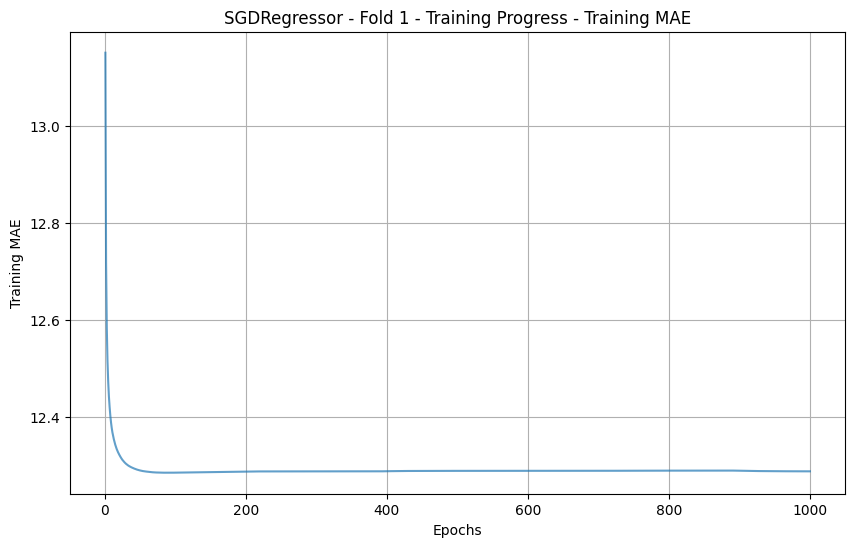

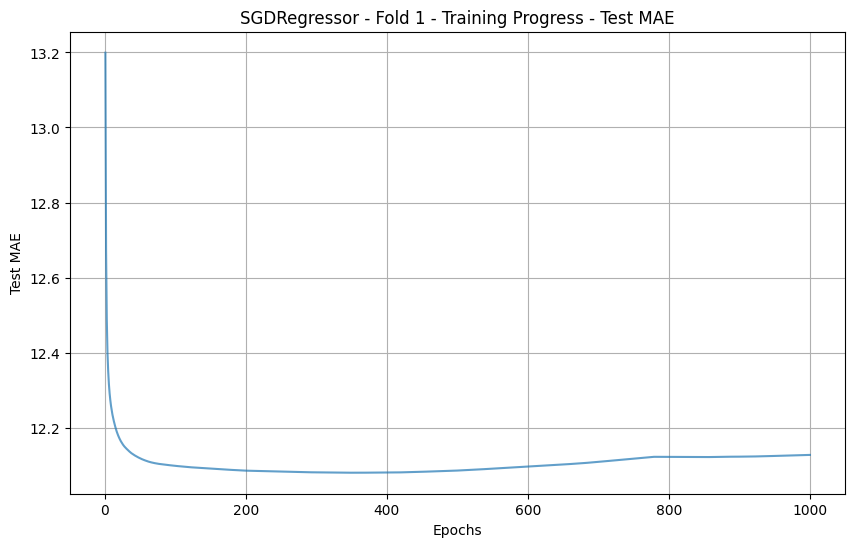

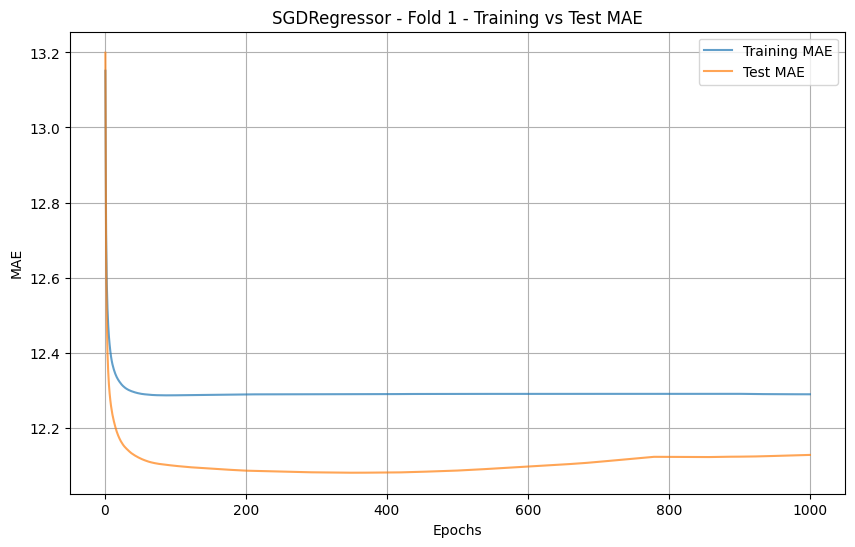

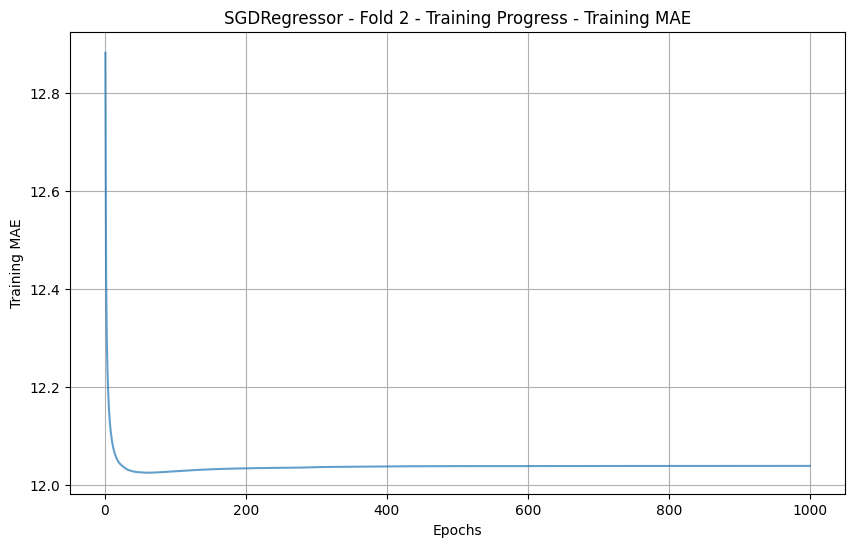

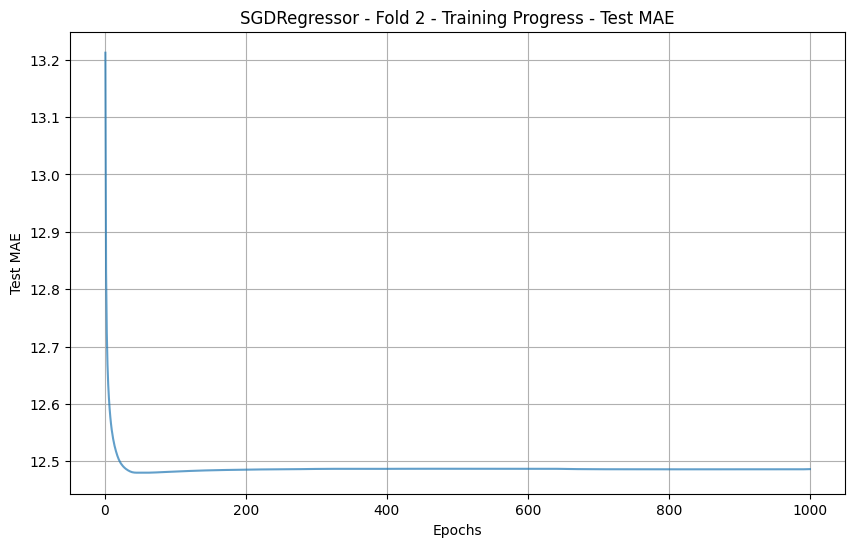

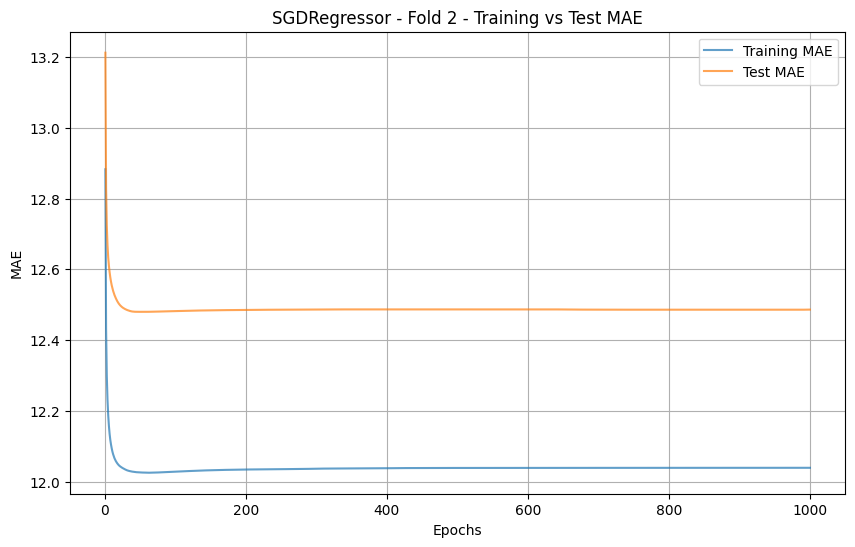

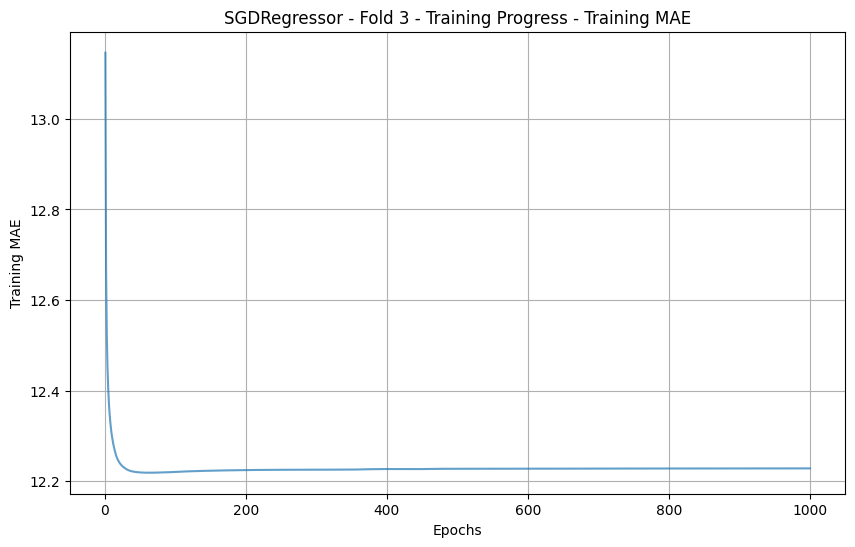

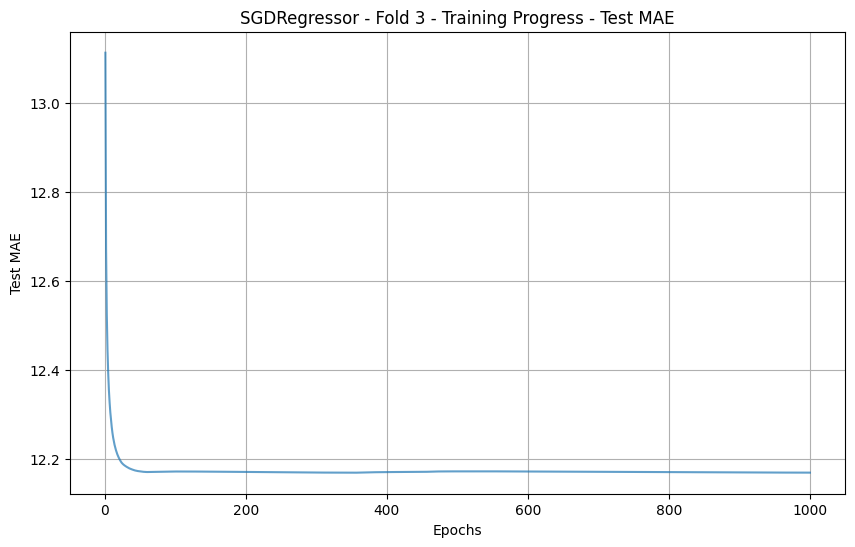

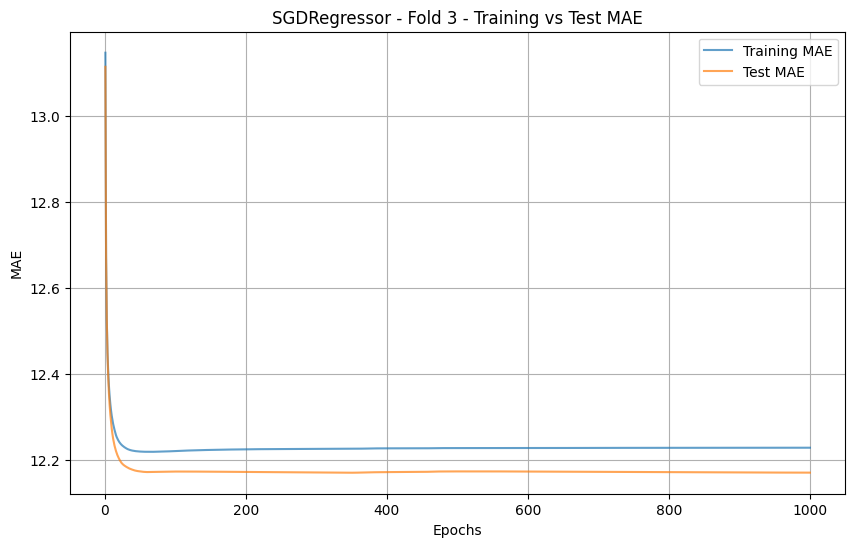

SGDRegressor - Average MAE: 12.2668 ± 0.1598

Running KNeighborsRegressor

KNeighborsRegressor - Fold 1:
----------------------------------------
Tracking progress by number of neighbors...
  k =  1: Train MAE = 0.2124, Test MAE = 13.2082
  k =  2: Train MAE = 7.0206, Test MAE = 12.3533
  k =  3: Train MAE = 8.7167, Test MAE = 12.3353
  k =  4: Train MAE = 9.4293, Test MAE = 12.1158
  k =  5: Train MAE = 9.8748, Test MAE = 11.9672
  k =  6: Train MAE = 10.2249, Test MAE = 11.9006
  k =  7: Train MAE = 10.4435, Test MAE = 11.8808
  k =  8: Train MAE = 10.7128, Test MAE = 11.9159
  k =  9: Train MAE = 10.8507, Test MAE = 11.9153
  k = 10: Train MAE = 10.9715, Test MAE = 11.9532
  k = 15: Train MAE = 11.4918, Test MAE = 12.1098
  k = 20: Train MAE = 11.7867, Test MAE = 12.2601
  k = 25: Train MAE = 11.9544, Test MAE = 12.4324
  k = 30: Train MAE = 12.2169, Test MAE = 12.6313
  k = 35: Train MAE = 12.4356, Test MAE = 12.7514
  k = 40: Train MAE = 12.5836, Test MAE = 12.8274
  k = 45: Train

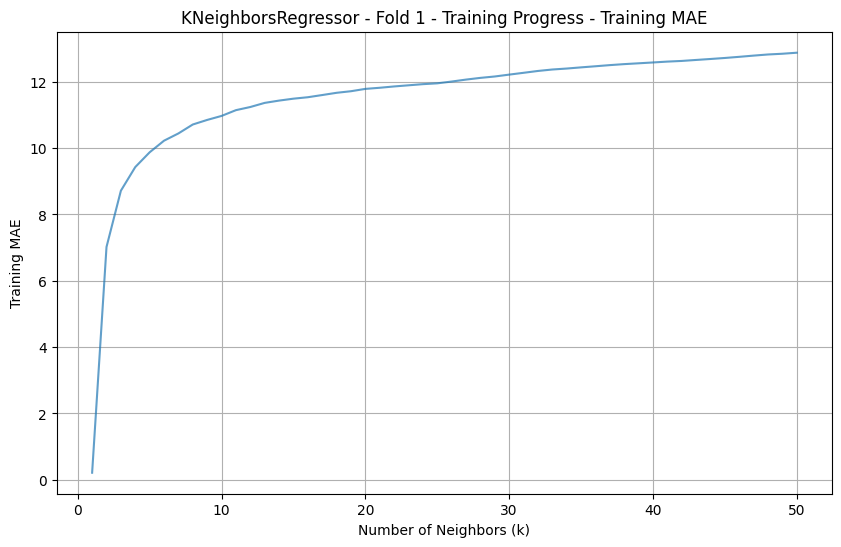

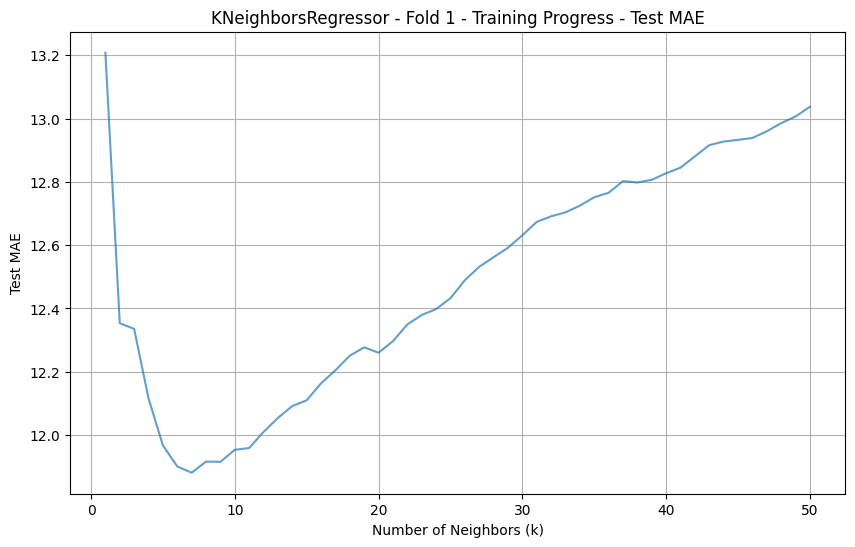

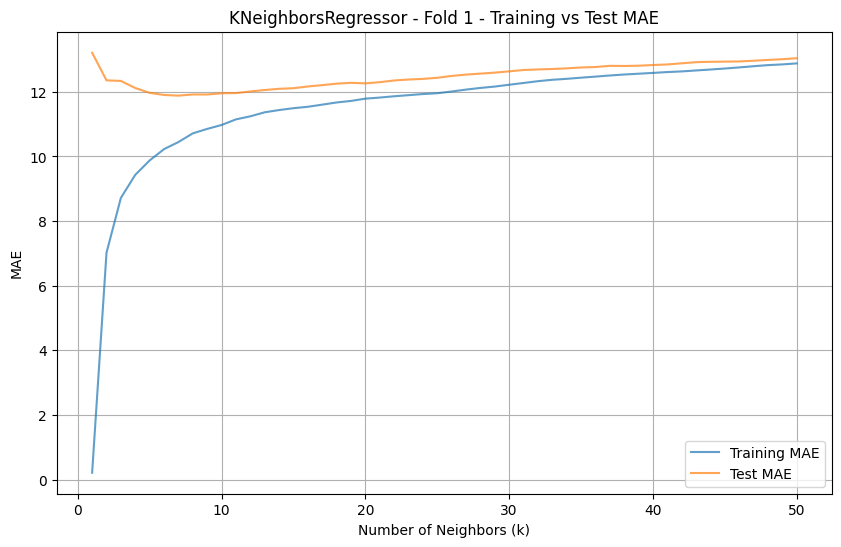

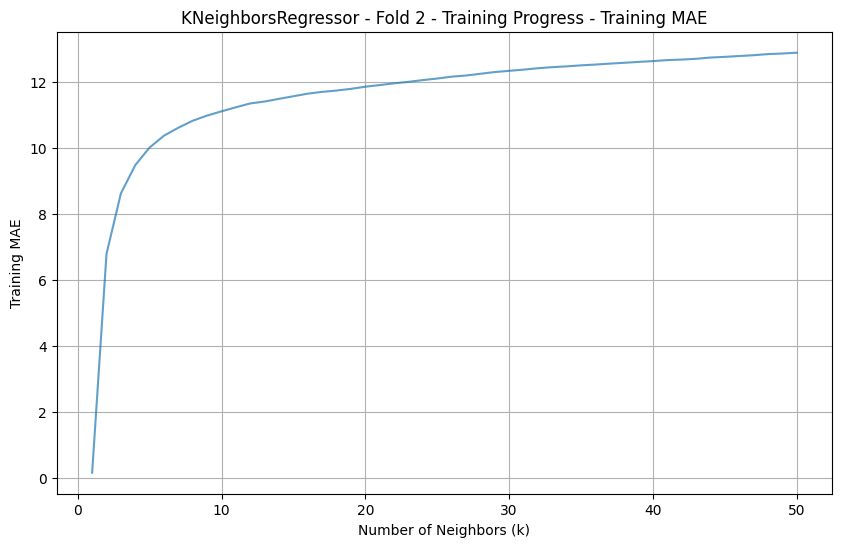

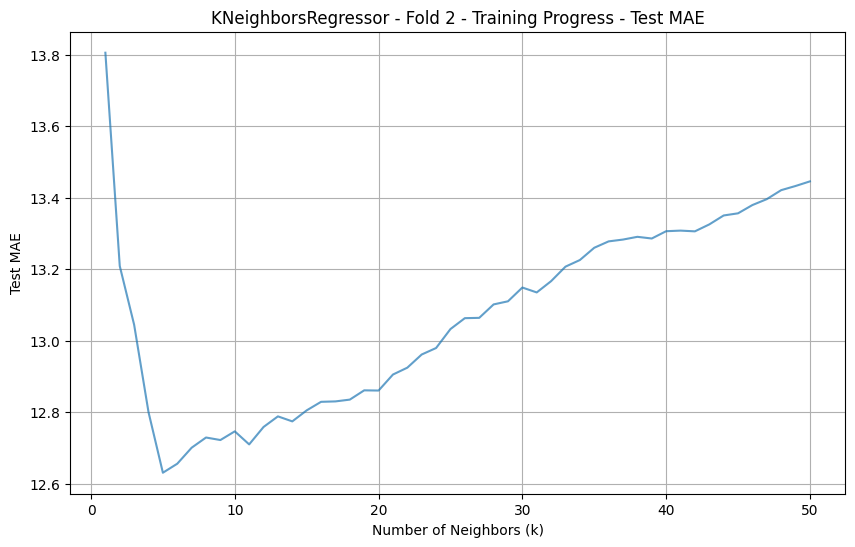

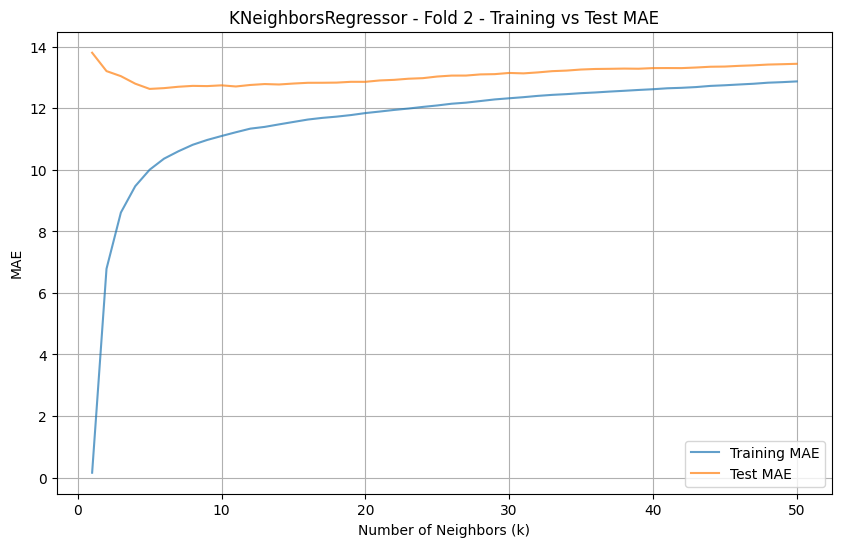

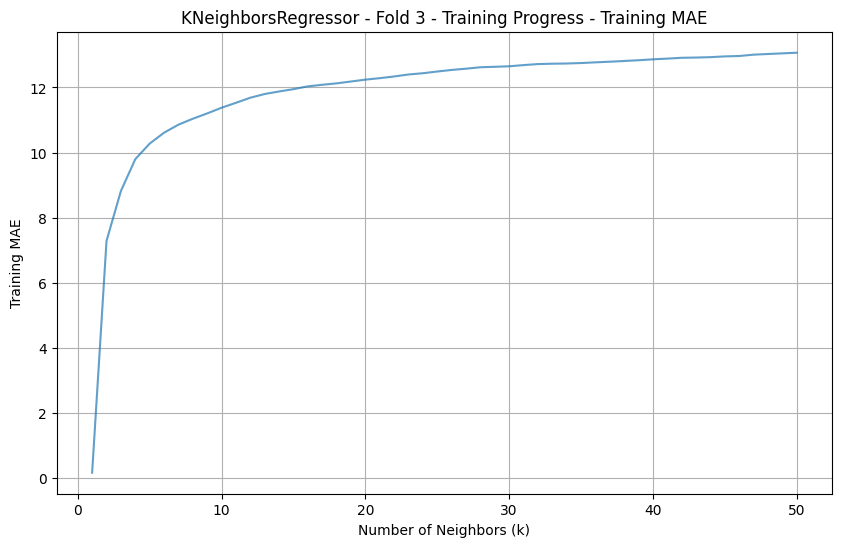

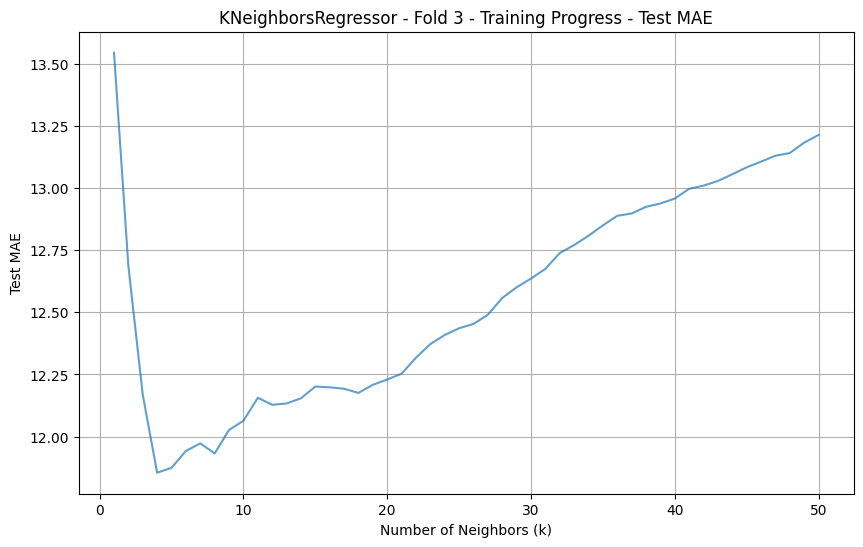

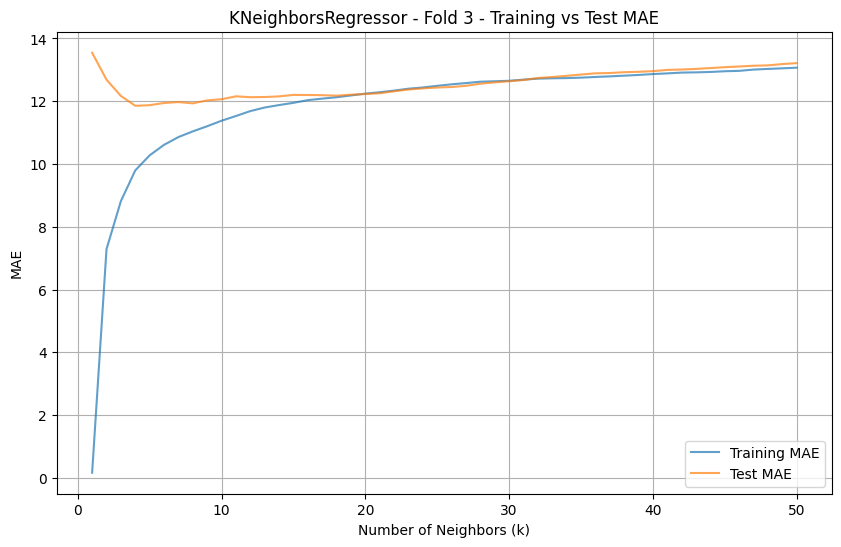

KNeighborsRegressor - Average MAE: 12.1572 ± 0.3367

Running RandomForestRegressor

RandomForestRegressor - Fold 1:
----------------------------------------
Tracking progress by number of estimators...
  Trees  20: Train MAE = 8.7713, Test MAE = 11.5025
  Trees  40: Train MAE = 8.7530, Test MAE = 11.4021
  Trees  50: Train MAE = 8.7419, Test MAE = 11.4034
RandomForestRegressor - Fold 1 Final MAE: 11.4034

RandomForestRegressor - Fold 2:
----------------------------------------
Tracking progress by number of estimators...
  Trees  20: Train MAE = 8.6051, Test MAE = 11.8391
  Trees  40: Train MAE = 8.5563, Test MAE = 11.7599
  Trees  50: Train MAE = 8.5548, Test MAE = 11.7695
RandomForestRegressor - Fold 2 Final MAE: 11.7695

RandomForestRegressor - Fold 3:
----------------------------------------
Tracking progress by number of estimators...
  Trees  20: Train MAE = 8.8535, Test MAE = 11.4163
  Trees  40: Train MAE = 8.8537, Test MAE = 11.3537
  Trees  50: Train MAE = 8.8481, Test MAE = 

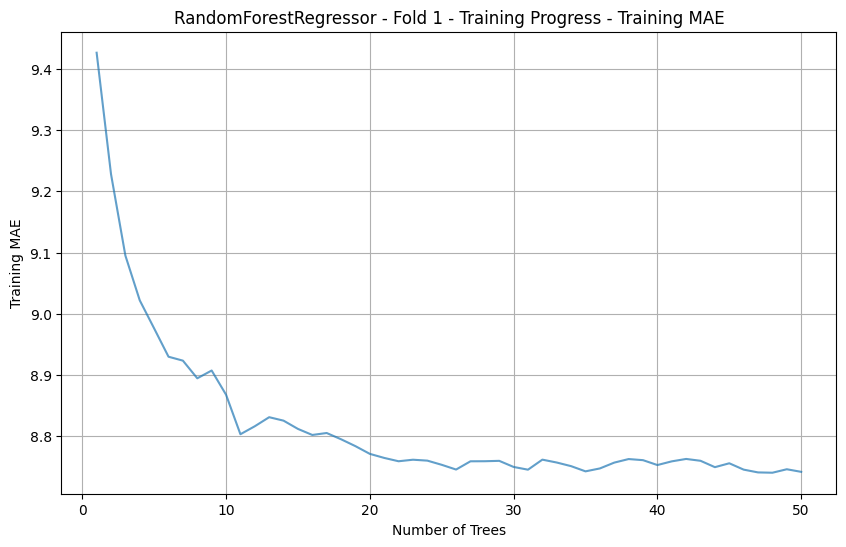

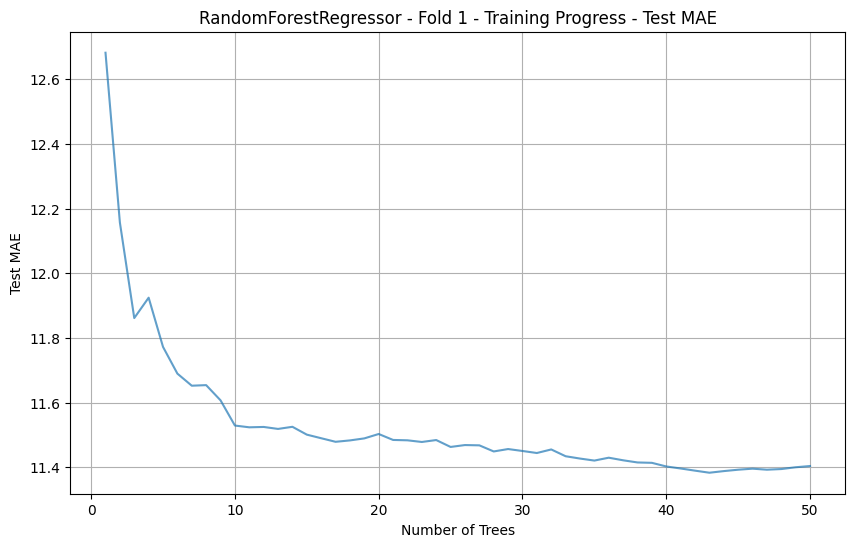

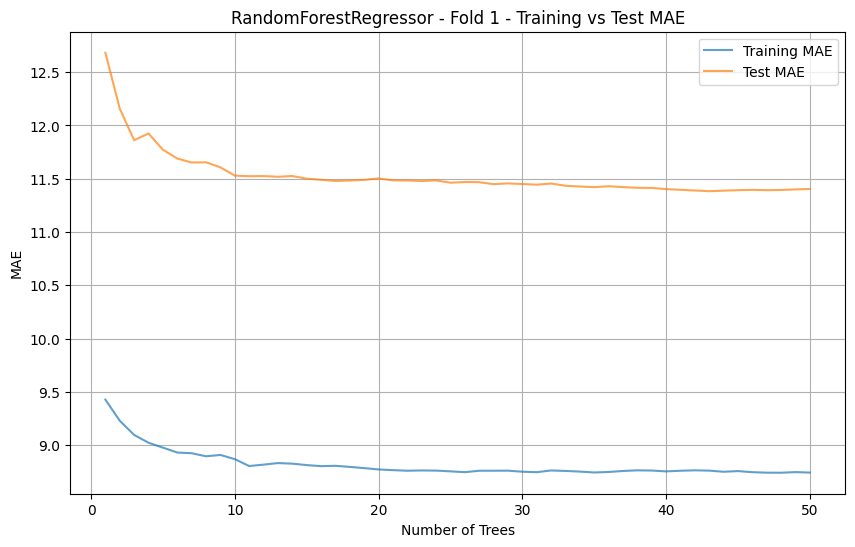

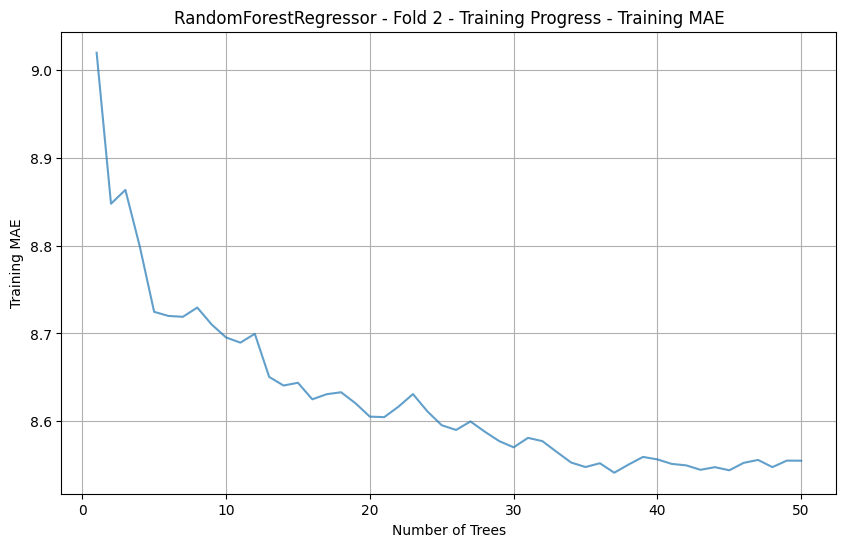

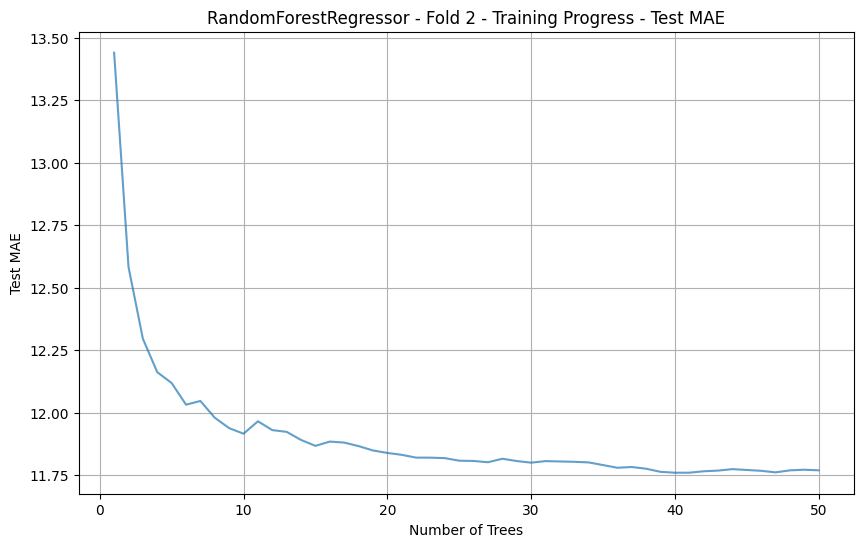

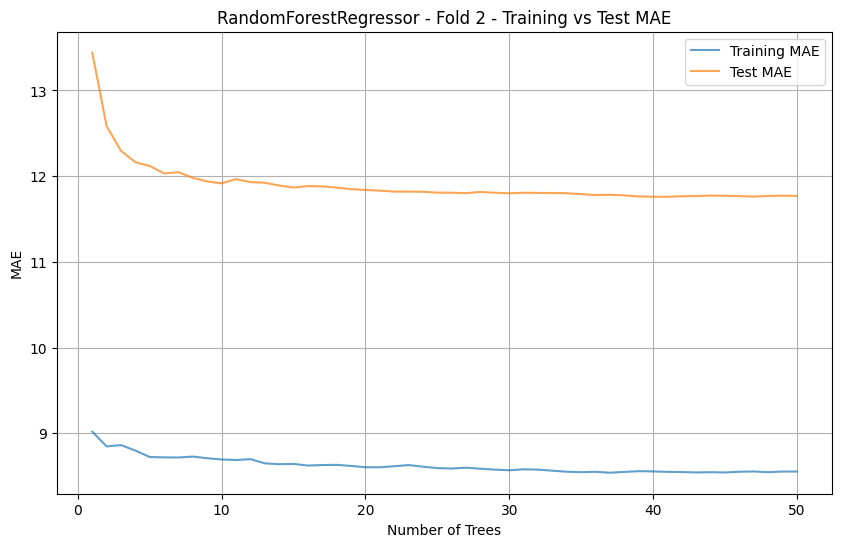

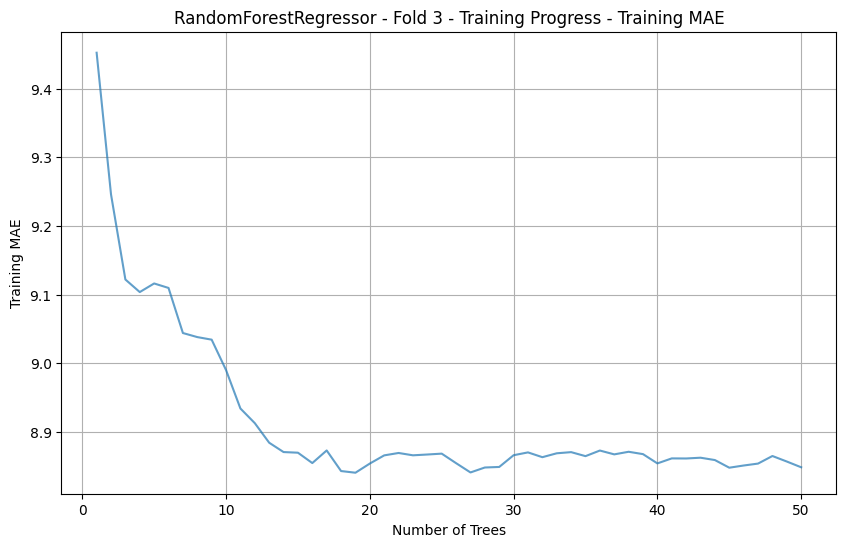

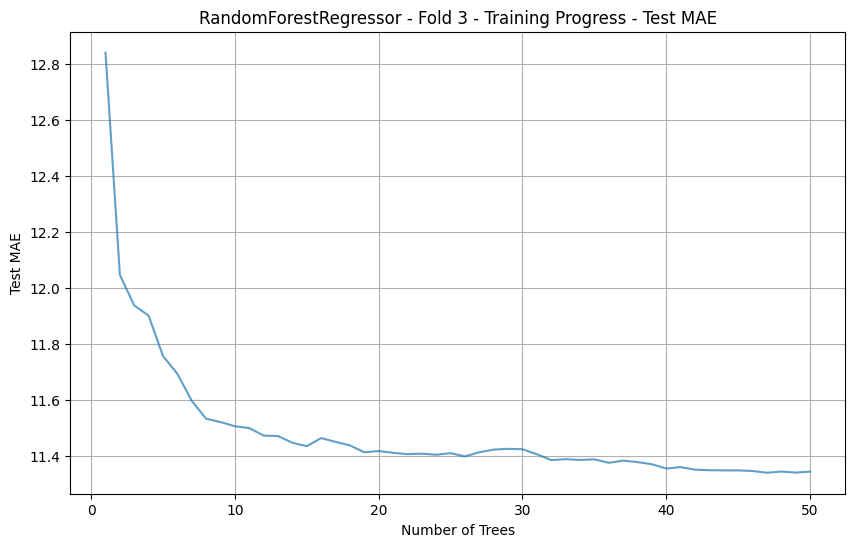

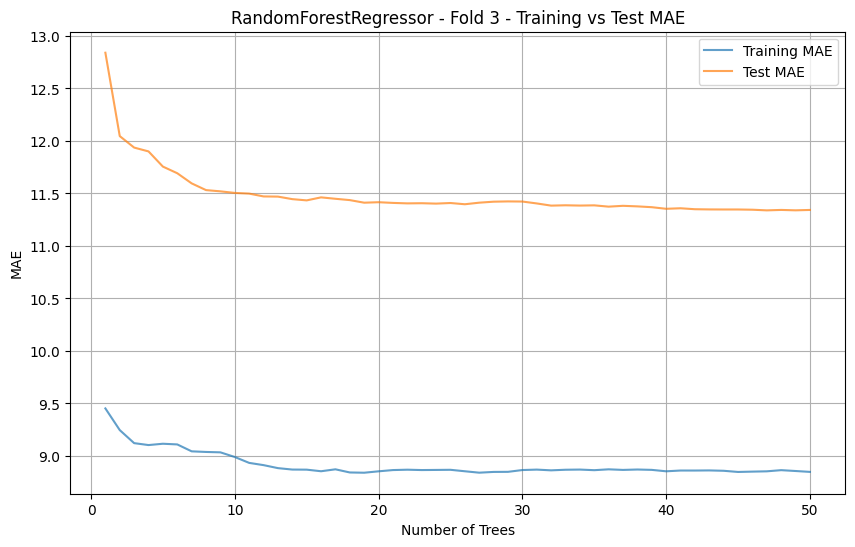

RandomForestRegressor - Average MAE: 11.5052 ± 0.1885

Running DecisionTreeRegressor

DecisionTreeRegressor - Fold 1:
----------------------------------------
Training model with fixed parameters...
  Final: Train MAE = 9.0012, Test MAE = 12.5303
DecisionTreeRegressor - Fold 1 Final MAE: 12.5303

DecisionTreeRegressor - Fold 2:
----------------------------------------
Training model with fixed parameters...
  Final: Train MAE = 8.4874, Test MAE = 12.4312
DecisionTreeRegressor - Fold 2 Final MAE: 12.4312

DecisionTreeRegressor - Fold 3:
----------------------------------------
Training model with fixed parameters...
  Final: Train MAE = 9.0740, Test MAE = 11.9165
DecisionTreeRegressor - Fold 3 Final MAE: 11.9165
Skipping plot for DecisionTreeRegressor - Fold 1 (only one data point)
Skipping plot for DecisionTreeRegressor - Fold 2 (only one data point)
Skipping plot for DecisionTreeRegressor - Fold 3 (only one data point)
DecisionTreeRegressor - Average MAE: 12.2927 ± 0.2691


In [35]:
def nested_cv_with_progress(X, y, model, param_grid, outer_cv=5, inner_cv=6, model_name=""):
    """
    Nested cross-validation using MAE as scoring metric with progress tracking
    - Outputs training and test MAE during training
    - Tracks performance with increasing epochs or k values
    - Returns data in format ready for plotting
    """
    outer_scores = []
    training_curves = []
    
    # Create MAE scorer (lower is better)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # STEP 1: Find best hyperparameters using inner CV on entire dataset
    if param_grid:
        print(f"{model_name} - Finding best parameters using inner CV...")
        inner_cv_splitter = KFold(n_splits=inner_cv, shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(
            estimator=clone(model),
            param_grid=param_grid,
            cv=inner_cv_splitter,
            scoring=mae_scorer,
            n_jobs=-1
        )
        
        grid_search.fit(X, y)
        best_params = grid_search.best_params_
        print(f"{model_name} - Best parameters found: {best_params}")
    else:
        best_params = {}
    
    # STEP 2: Outer CV with training progress tracking
    outer_cv_splitter = KFold(n_splits=outer_cv, shuffle=True, random_state=42)
    
    for fold, (train_idx, test_idx) in enumerate(outer_cv_splitter.split(X, y)):
        X_train_outer, X_test_outer = X[train_idx], X[test_idx]
        y_train_outer, y_test_outer = y[train_idx], y[test_idx]
        
        print(f"\n{model_name} - Fold {fold + 1}:")
        print("-" * 40)
        
        # Train model with the fixed best parameters
        current_model = clone(model)
        if best_params:
            current_model.set_params(**best_params)
        
        # Custom training loop for models that support partial_fit or have n_estimators/epochs
        fold_training_curve = track_training_progress(
            current_model, X_train_outer, y_train_outer, X_test_outer, y_test_outer, model_name, fold
        )
        
        training_curves.append(fold_training_curve)
        
        # Final evaluation - ensure model is fitted
        if hasattr(current_model, 'fit'):
            current_model.fit(X_train_outer, y_train_outer)
        y_pred = current_model.predict(X_test_outer)
        mae_score = mean_absolute_error(y_test_outer, y_pred)
        outer_scores.append(mae_score)
        
        print(f"{model_name} - Fold {fold + 1} Final MAE: {mae_score:.4f}")
    
    return outer_scores, best_params, training_curves


def track_training_progress(model, X_train, y_train, X_test, y_test, model_name, fold):
    """
    Track training and validation MAE during model training
    Returns data in format ready for plotting
    """
    training_curve = {
        'fold': fold + 1,
        'iterations': [],
        'train_mae': [],
        'test_mae': [],
        'model_type': model_name
    }
    
    # Handle different model types
    if hasattr(model, 'partial_fit'):  # SGDRegressor and similar
        print("Tracking progress by epochs...")
        n_epochs = model.get_params().get('max_iter', 1000)
        training_curve['xlabel'] = 'Epochs'
        training_curve['title'] = f'{model_name} - Fold {fold + 1} - Training Progress'
        
        # Initialize the model
        model.partial_fit(X_train, y_train)
        
        for epoch in range(1, n_epochs + 1):
            if epoch > 1:
                model.partial_fit(X_train, y_train)
            
            # Calculate training and test MAE
            train_pred = model.predict(X_train)
            test_pred = model.predict(X_test)
            
            train_mae = mean_absolute_error(y_train, train_pred)
            test_mae = mean_absolute_error(y_test, test_pred)
            
            training_curve['iterations'].append(epoch)
            training_curve['train_mae'].append(train_mae)
            training_curve['test_mae'].append(test_mae)
            
            # Print progress every 100 epochs or at the end
            if epoch % 100 == 0 or epoch == n_epochs:
                print(f"  Epoch {epoch:4d}: Train MAE = {train_mae:.4f}, Test MAE = {test_mae:.4f}")
    
    elif hasattr(model, 'n_estimators') and hasattr(model, 'warm_start'):  # RandomForest with warm_start
        print("Tracking progress by number of estimators...")
        n_estimators = model.get_params().get('n_estimators', 100)
        training_curve['xlabel'] = 'Number of Trees'
        training_curve['title'] = f'{model_name} - Fold {fold + 1} - Training Progress'
        
        # Enable warm_start for incremental training
        model.set_params(warm_start=True)
        
        for n_est in range(1, n_estimators + 1):
            model.set_params(n_estimators=n_est)
            model.fit(X_train, y_train)
            
            train_pred = model.predict(X_train)
            test_pred = model.predict(X_test)
            
            train_mae = mean_absolute_error(y_train, train_pred)
            test_mae = mean_absolute_error(y_test, test_pred)
            
            training_curve['iterations'].append(n_est)
            training_curve['train_mae'].append(train_mae)
            training_curve['test_mae'].append(test_mae)
            
            if n_est % 20 == 0 or n_est == n_estimators:
                print(f"  Trees {n_est:3d}: Train MAE = {train_mae:.4f}, Test MAE = {test_mae:.4f}")
    
    elif hasattr(model, 'n_neighbors'):  # KNN - track different k values
        print("Tracking progress by number of neighbors...")
        max_neighbors = min(50, len(X_train) - 1)  # Limit to reasonable range
        training_curve['xlabel'] = 'Number of Neighbors (k)'
        training_curve['title'] = f'{model_name} - Fold {fold + 1} - Training Progress'
        
        for k in range(1, max_neighbors + 1):
            # Create a new KNN model for each k value
            knn_model = KNeighborsRegressor(
                n_neighbors=k,
                weights=model.weights,
                metric=model.metric
            )
            knn_model.fit(X_train, y_train)
            
            train_pred = knn_model.predict(X_train)
            test_pred = knn_model.predict(X_test)
            
            train_mae = mean_absolute_error(y_train, train_pred)
            test_mae = mean_absolute_error(y_test, test_pred)
            
            training_curve['iterations'].append(k)
            training_curve['train_mae'].append(train_mae)
            training_curve['test_mae'].append(test_mae)
            
            if k % 5 == 0 or k == max_neighbors or k <= 10:
                print(f"  k = {k:2d}: Train MAE = {train_mae:.4f}, Test MAE = {test_mae:.4f}")
    
    else:
        # For models without incremental training (DecisionTree, Dummy, etc.)
        print("Training model with fixed parameters...")
        model.fit(X_train, y_train)
        
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        train_mae = mean_absolute_error(y_train, train_pred)
        test_mae = mean_absolute_error(y_test, test_pred)
        
        # For non-incremental models, we'll just show the final result
        training_curve['iterations'] = [1]
        training_curve['train_mae'] = [train_mae]
        training_curve['test_mae'] = [test_mae]
        training_curve['xlabel'] = 'Iteration'
        training_curve['title'] = f'{model_name} - Fold {fold + 1} - Final Result'
        
        print(f"  Final: Train MAE = {train_mae:.4f}, Test MAE = {test_mae:.4f}")
    
    return training_curve


# Enhanced plotting functions
def plot_training_curves(training_curves, plot_type='individual'):
    """
    Plot training curves using the provided plot function
    """
    if plot_type == 'individual':
        for curve in training_curves:
            if len(curve['iterations']) > 1:  # Only plot if we have multiple data points
                # Plot training MAE
                plot(
                    curve['iterations'], 
                    curve['train_mae'],
                    title=f"{curve['title']} - Training MAE",
                    xlabel=curve['xlabel'],
                    ylabel='Training MAE'
                )
                
                # Plot test MAE
                plot(
                    curve['iterations'], 
                    curve['test_mae'],
                    title=f"{curve['title']} - Test MAE",
                    xlabel=curve['xlabel'],
                    ylabel='Test MAE'
                )
                
                # Plot both together
                plt.figure(figsize=(10, 6))
                plt.plot(curve['iterations'], curve['train_mae'], label='Training MAE', alpha=0.7)
                plt.plot(curve['iterations'], curve['test_mae'], label='Test MAE', alpha=0.7)
                plt.title(f"{curve['model_type']} - Fold {curve['fold']} - Training vs Test MAE")
                plt.xlabel(curve['xlabel'])
                plt.ylabel('MAE')
                plt.legend()
                plt.grid(True)
                plt.show()
            else:
                print(f"Skipping plot for {curve['model_type']} - Fold {curve['fold']} (only one data point)")
    
    elif plot_type == 'average':
        # Average across folds for the same iteration points
        if training_curves and len(training_curves[0]['iterations']) > 1:
            # Find common iteration points (take the minimum length to be safe)
            min_iterations = min(len(curve['iterations']) for curve in training_curves)
            iterations = training_curves[0]['iterations'][:min_iterations]
            
            avg_train_mae = np.zeros(min_iterations)
            avg_test_mae = np.zeros(min_iterations)
            
            for curve in training_curves:
                avg_train_mae += curve['train_mae'][:min_iterations]
                avg_test_mae += curve['test_mae'][:min_iterations]
            
            avg_train_mae /= len(training_curves)
            avg_test_mae /= len(training_curves)
            
            # Plot averaged curves
            plot(
                iterations, avg_train_mae,
                title=f"{training_curves[0]['model_type']} - Average Training MAE",
                xlabel=training_curves[0]['xlabel'],
                ylabel='Average Training MAE'
            )
            
            plot(
                iterations, avg_test_mae,
                title=f"{training_curves[0]['model_type']} - Average Test MAE",
                xlabel=training_curves[0]['xlabel'],
                ylabel='Average Test MAE'
            )
            
            # Plot both together
            plt.figure(figsize=(10, 6))
            plt.plot(iterations, avg_train_mae, label='Average Training MAE', alpha=0.7)
            plt.plot(iterations, avg_test_mae, label='Average Test MAE', alpha=0.7)
            plt.title(f"{training_curves[0]['model_type']} - Average Training Progress")
            plt.xlabel(training_curves[0]['xlabel'])
            plt.ylabel('MAE')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"Cannot average - not enough data points for {training_curves[0]['model_type']}")


# Example usage:
def run_and_plot_models(X, y, models_dict):
    """
    Run models and automatically plot training curves
    """
    all_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n{'='*60}")
        print(f"Running {model_name}")
        print(f"{'='*60}")
        
        # Run nested CV with progress tracking
        scores, best_params, training_curves = nested_cv_with_progress(
            X, y, model, param_grid=None, 
            outer_cv=3,  # Use fewer folds for faster demonstration
            model_name=model_name
        )
        
        all_results[model_name] = {
            'scores': scores,
            'best_params': best_params,
            'training_curves': training_curves
        }
        
        # Plot training curves
        plot_training_curves(training_curves, plot_type='individual')
        
        print(f"{model_name} - Average MAE: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
    return all_results


# Create models configured for tracking
def create_trackable_models():
    return {
        'DummyRegressor': DummyRegressor(strategy='median'),
        'SGDRegressor': SGDRegressor(
            penalty='l1',
            alpha=0.01,
            l1_ratio=0.15,
            learning_rate='invscaling',
            eta0=0.01,
            max_iter=1000,  # Reduced for demonstration
            random_state=42,
            warm_start=False
        ),
        'KNeighborsRegressor': KNeighborsRegressor(
            n_neighbors=5,
            weights='uniform',
            metric='euclidean'
        ),
        'RandomForestRegressor': RandomForestRegressor(
            n_estimators=50,  # Reduced for demonstration
            max_depth=10,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=42,
            warm_start=True  # Enable incremental training
        ),
        'DecisionTreeRegressor': DecisionTreeRegressor(
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )
    }
#{'alpha': 0.01, 'eta0': 0.01, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'max_iter': 1000, 'penalty': 'l1'}
track_models = create_trackable_models()
results = run_and_plot_models(x_num_minmax, y_num, track_models)

In [32]:
def nested_cv_best_model(X, y, model, param_grid, outer_cv=5, inner_cv=6, model_name=""):
    """
    Nested cross-validation using MAE as scoring metric.
    - Step 1: Find best hyperparameters using inner CV on entire dataset.
    - Step 2: Evaluate model with those hyperparameters using outer CV.
    Returns per-fold MAE scores, best hyperparameters, and best fitted model.

    Parameters
    ----------
    X : array-like
        Input features.
    y : array-like
        Target values.
    model : estimator
        Base model instance (not yet fitted).
    param_grid : dict
        Hyperparameter grid for tuning.
    outer_cv : int, optional
        Number of folds for outer CV (default 5).
    inner_cv : int, optional
        Number of folds for inner CV (default 5).
    model_name : str, optional
        Name of the model (for logging).

    Returns
    -------
    outer_scores : list
        List of MAE scores from outer CV.
    best_params : dict
        Best hyperparameters found from inner CV.
    best_model : estimator
        Best model refitted on the full dataset with best hyperparameters.
    mean_mae : float
        Mean MAE across all outer CV folds.
    """
    outer_scores = []

    # Create MAE scorer (lower is better)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # STEP 1: Find best hyperparameters using inner CV
    if param_grid:
        print(f"{model_name} - Finding best parameters using inner CV...")
        inner_cv_splitter = KFold(n_splits=inner_cv, shuffle=True, random_state=42)

        grid_search = GridSearchCV(
            estimator=clone(model),
            param_grid=param_grid,
            cv=inner_cv_splitter,
            scoring=mae_scorer,
            n_jobs=-1
        )

        grid_search.fit(X, y)
        best_params = grid_search.best_params_
        print(f"{model_name} - Best parameters found: {best_params}")
    else:
        best_params = {}

    # STEP 2: Outer CV with fixed best parameters
    outer_cv_splitter = KFold(n_splits=outer_cv, shuffle=True, random_state=42)

    for fold, (train_idx, test_idx) in enumerate(outer_cv_splitter.split(X, y)):
        X_train_outer, X_test_outer = X[train_idx], X[test_idx]
        y_train_outer, y_test_outer = y[train_idx], y[test_idx]

        # Train model with the fixed best parameters
        current_model = clone(model)
        if best_params:
            current_model.set_params(**best_params)

        current_model.fit(X_train_outer, y_train_outer)
        y_pred = current_model.predict(X_test_outer)
        mae_score = mean_absolute_error(y_test_outer, y_pred)

        outer_scores.append(mae_score)
        print(f"{model_name} - Fold {fold + 1}: MAE = {mae_score:.4f}")

    # Calculate mean MAE
    mean_mae = np.mean(outer_scores)
    std_mae = np.std(outer_scores)
    print(f"{model_name} - Mean MAE: {mean_mae:.4f} ± {std_mae:.4f}")

    # STEP 3: Fit the best model on the full dataset
    best_model = clone(model)
    if best_params:
        best_model.set_params(**best_params)
    best_model.fit(X, y)

    return outer_scores, best_params, best_model, mean_mae

# Run nested CV and get the mean MAE automatically
outer_scores, best_params, best_model, mean_mae = nested_cv_best_model(
    X=x_num_stan,
    y=y_num,
    model=RandomForestRegressor(),
    param_grid={
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
    outer_cv=5,
    inner_cv=3,
    model_name="RandomForestRegressor"
)

def create_submission_file(mae_estimate, predictions_list, filename="submission.txt"):
    """
    Create a submission file with MAE estimate on first line and predictions on subsequent lines
    
    Parameters:
    mae_estimate: Your MAE estimate (float or string)
    predictions_list: List of prediction values
    filename: Output filename
    """
    with open(filename, 'w') as f:
        # Write MAE estimate on first line
        f.write(f"{mae_estimate}\n")
        
        # Write each prediction on a new line
        for prediction in predictions_list:
            f.write(f"{prediction}\n")
    
    print(f"File '{filename}' created successfully!")
    print(f"First line (MAE): {mae_estimate}")
    print(f"Number of predictions: {len(predictions_list)}")

# Make predictions on new data
y_pred_new = best_model.predict(x_auto_stan)

# Save predictions to a list
predictions_list = list(y_pred_new)

# Use the mean MAE from cross-validation automatically
my_mae_estimate = mean_mae  # This is now the mean from the folds

print(f"\nUsing mean MAE from cross-validation: {my_mae_estimate:.6f}")

create_submission_file(my_mae_estimate, predictions_list)

RandomForestRegressor - Finding best parameters using inner CV...
RandomForestRegressor - Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestRegressor - Fold 1: MAE = 11.6505
RandomForestRegressor - Fold 2: MAE = 10.8924
RandomForestRegressor - Fold 3: MAE = 11.7805
RandomForestRegressor - Fold 4: MAE = 11.2409
RandomForestRegressor - Fold 5: MAE = 11.2498
RandomForestRegressor - Mean MAE: 11.3628 ± 0.3182

Using mean MAE from cross-validation: 11.362821
File 'submission.txt' created successfully!
First line (MAE): 11.362821155093531
Number of predictions: 17272
